In [9]:
from vina import Vina
from openbabel import openbabel as ob
from openbabel import pybel as pb
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
import time
import rdkit
import matplotlib.pyplot as plt
import random
import math
import re
import os
import numpy as np

In [10]:
class SimulatedAnnealingOld:
    def __init__(self, fragments: list[str], vina: Vina):
        self.fragments = fragments
        self.vina:Vina = vina
        self.grid_box = None  #[0=> center, 1=>size]

    def setTarget(self, target_pdbqt_path: str, grid_param: tuple[int, list[int, int, int], list[int, int, int]] = None):
        '''
        grid_param = (spacing, center, box)
        '''
        self.vina.set_receptor(target_pdbqt_path)

        if grid_param is not None:
            self.setGridMap(grid_param)

    def setGridMap(self, grid_param: tuple[int, list[int, int, int], list[int, int, int]]):
        '''
        grid_param = (spacing, center, box)
        '''
        self.grid_box = [grid_param[1], grid_param[2]]
        if grid_param[0] == None:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2])
        else:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2], spacing=grid_param[0])

    def generateRdkitConformer(self, mol:rdkit.Chem.rdchem.Mol) -> rdkit.Chem.rdchem.Mol:
        '''input is rdkit mol and conformer is added to to same input mol and mol is also returned
        if it fails it will return None
        '''
        mol = AllChem.AddHs(mol)
        sucess = AllChem.EmbedMolecule(mol)

        if sucess == -1:
            return None

        return mol

    def placeRdkitMolAtNewPoint(self, mol: rdkit.Chem.rdchem.Mol, atom_idx: int, new_x: float, new_y: float, new_z: float) ->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule(conformer), conformer should be created for this method to work
        '''
        c = mol.GetConformer()
        atom_point = c.GetAtomPosition(atom_idx)
        x_offset = new_x - atom_point.x
        y_offset = new_y - atom_point.y
        z_offset = new_z - atom_point.z

        mol = self.shiftRdkitMol(mol, x_offset, y_offset, z_offset)

        return mol


    def shiftRdkitMol(self, mol: rdkit.Chem.rdchem.Mol, x_offset: float, y_offset: float, z_offset: float)->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule, offeset is, conformer should be created for this method to work
        '''

        c = mol.GetConformer()

        # shift all atoms
        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            pos.x += x_offset
            pos.y += y_offset
            pos.z += z_offset

            c.SetAtomPosition(i, pos)

        return mol

    def alignMolWithSubMol(self, mol, submol): # does not align hydrogen, mol as probe and submol as reference for alignment
        sc = submol.GetConformer()
        submol_index = [atom.GetIdx() for atom in submol.GetAtoms() if atom.GetAtomicNum()!=1]

        c = mol.GetConformer()
        mol_index = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum()!=1]

        atomMap = []
        for i in range(len(submol_index)):
            atomMap.append((mol_index[i], submol_index[i]))

        AllChem.AlignMol(mol, submol, atomMap=atomMap)

        return mol

    def getScore(self, ligand_pdbqt: str):
        '''return score of input ligand pose using vina
        '''
        self.vina.set_ligand_from_string(ligand_pdbqt)
        score = self.vina.score()

        return score[0]


    def rdkitToPdbqt(self, mol: rdkit.Chem.rdchem.Mol)->str:
        '''return pdbqt string of given rdkit mol
        '''
        mol_block = Chem.MolToMolBlock(mol) # sdf format

        pymol = pb.readstring(format="sdf", string=mol_block)
        pdbqt = pymol.write(format="pdbqt")

        return pdbqt

    def getRandomFragment(self) -> str:
        idx = random.randint(0, len(self.fragments)-1)
        self.idx = idx
        return self.fragments[idx]
        
    
    def isLigInGridbox(self,  mol: rdkit.Chem.rdchem.Mol):
        '''
        Returns true if all atoms of ligands(mol) are present inside the grid box
        '''
        c = mol.GetConformer()
        center = self.grid_box[0]
        size = self.grid_box[1]
        
        x_min = center[0] - size[0] / 2
        x_max = center[0] + size[0] / 2
        y_min = center[1] - size[1] / 2
        y_max = center[1] + size[1] / 2
        z_min = center[2] - size[2] / 2
        z_max = center[2] + size[2] / 2

        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            if (x_min <= pos.x <= x_max) and (y_min <= pos.y <= y_max) and (z_min <= pos.z <= z_max) is False:
                return False
        
        return True


    def simulatedAnnealingRecursive(self, 
                                    old_ligand: str,
                                    old_score: float, 
                                    old_ligand_3d, 
                                    initial_position: list, 
                                    max_mw: float, 
                                    temp: float, 
                                    iter: int, 
                                    coolingSchedule)-> dict:
        
        for i in range(100):
            frag = self.getRandomFragment()

            new_lig = old_ligand + frag

            try:
                mol = Chem.MolFromSmiles(new_lig)
                mol = self.generateRdkitConformer(mol)
            except:
                continue

            if mol is None:
                continue

            if old_ligand is None or old_ligand == '':
                # if current/new fragment is the first fragment then place this fragment at initial position
                mol = self.placeRdkitMolAtNewPoint(mol, 0, initial_position[0], initial_position[1], initial_position[2])
            else:
                # else align new/current mol to old molecule
                mol = self.alignMolWithSubMol(mol, old_ligand_3d)

            # checking if ligand is present inside grid box, if not then try other fragment
            if self.isLigInGridbox(mol) is False:
                continue

            # calculationg score of new/current ligand using vina
            pdbqt = self.rdkitToPdbqt(mol)
            
            new_score = self.getScore(pdbqt)
            del_score = new_score - old_score
            new_Temp = coolingSchedule(temp, iter)
            if del_score <= 0 or random.random() < math.exp(-del_score / new_Temp):
                
                if Descriptors.MolWt(mol) >= max_mw:
                    return (mol, new_lig, new_score)
                else:
                    result = self.simulatedAnnealingRecursive(old_ligand=new_lig, 
                                                              old_score=new_score, 
                                                              old_ligand_3d=mol, 
                                                              initial_position=initial_position, 
                                                              max_mw=max_mw, 
                                                              temp=temp, 
                                                              iter=iter+1,
                                                              coolingSchedule=coolingSchedule)
                    if result is not None:
                        return result
        return None




    def simulatedAnnealing(self, ligand:str='', 
                           start_score: float=0, 
                           ligand_3d=None, 
                           initial_building_position: list = [0, 0, 0], 
                           max_mw: float=100, 
                           temp: float=3000, 
                           iter = 0, 
                           coolingSchedule=None):
        return self.simulatedAnnealingRecursive(old_ligand=ligand, 
                                                old_score=start_score, 
                                                old_ligand_3d=ligand_3d, 
                                                initial_position=initial_building_position, 
                                                max_mw=max_mw, 
                                                temp=temp, 
                                                iter=iter, 
                                                coolingSchedule=coolingSchedule)



In [11]:
# adding fragments in between
class SimulatedAnnealing:
    def __init__(self, fragments: list[str], vina: Vina):
        self.fragments = fragments
        self.vina:Vina = vina
        self.grid_box = None  #[0=> center, 1=>size]

    def setTarget(self, target_pdbqt_path: str, grid_param: tuple[int, list[int, int, int], list[int, int, int]] = None):
        '''
        grid_param = (spacing, center, box)
        '''
        self.vina.set_receptor(target_pdbqt_path)

        if grid_param is not None:
            self.setGridMap(grid_param)

    def setGridMap(self, grid_param: tuple[int, list[int, int, int], list[int, int, int]]):
        '''
        grid_param = (spacing, center, box)
        '''
        self.grid_box = [grid_param[1], grid_param[2]]
        if grid_param[0] == None:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2])
        else:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2], spacing=grid_param[0])

    def generateRdkitConformer(self, mol:rdkit.Chem.rdchem.Mol) -> rdkit.Chem.rdchem.Mol:
        '''input is rdkit mol and conformer is added to to same input mol and mol is also returned
        if it fails it will return None
        '''
        mol = AllChem.AddHs(mol)
        sucess = AllChem.EmbedMolecule(mol)

        if sucess == -1:
            return None

        return mol

    def placeRdkitMolAtNewPoint(self, mol: rdkit.Chem.rdchem.Mol, atom_idx: int, new_x: float, new_y: float, new_z: float) ->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule(conformer), conformer should be created for this method to work
        '''
        c = mol.GetConformer()
        atom_point = c.GetAtomPosition(atom_idx)
        x_offset = new_x - atom_point.x
        y_offset = new_y - atom_point.y
        z_offset = new_z - atom_point.z

        mol = self.shiftRdkitMol(mol, x_offset, y_offset, z_offset)

        return mol


    def shiftRdkitMol(self, mol: rdkit.Chem.rdchem.Mol, x_offset: float, y_offset: float, z_offset: float)->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule, offeset is, conformer should be created for this method to work
        '''

        c = mol.GetConformer()

        # shift all atoms
        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            pos.x += x_offset
            pos.y += y_offset
            pos.z += z_offset

            c.SetAtomPosition(i, pos)

        return mol

    def addFragmentRandomlyToLigandSmiles(self, lig_smile, frag_smile, chain_prob):
        '''Return new_smile and atom Map
        '''
        # total atoms in ligand smiles
        avaliable_idxs = [-1] # -1 so that at 0th place string can be added
        # for chain
        for i in range(len(lig_smile)): 
            if lig_smile[i].isalpha() == True: 
                avaliable_idxs.append(i)
        avaliable_idxs.append(len(lig_smile)) # for end 

        # probablities
        chain_prob = 0.1
        end_prob = 1-chain_prob
        avaliable_idx_probs = []
        for i in range(len(avaliable_idxs)):
            if i == 0 or i==len(avaliable_idxs)-1: avaliable_idx_probs.append(end_prob/2)
            else: avaliable_idx_probs.append(chain_prob/(len(avaliable_idxs)-2))

        # random position
        position = random.choices(
            population=avaliable_idxs,
            weights=avaliable_idx_probs,
            k=1
        )[0]

        new_lig_smile = ''
        insert_len = len(frag_smile)
        if position == avaliable_idxs[0]:
            new_lig_smile = frag_smile + lig_smile
        elif position == avaliable_idxs[-1]:
            new_lig_smile =  lig_smile + frag_smile
        else:
            insert_len += 2
            new_lig_smile = lig_smile[0:position+1] + '('+ frag_smile+')' + lig_smile[position+1:]


        # creating map
        lig_idx2atom = dict()
        atom_idx = 0
        for i in range(len(lig_smile)): 
            if lig_smile[i].isalpha() == True: 
                lig_idx2atom[i] = atom_idx
                atom_idx += 1

        new_lig_idx2atom = dict()
        atom_idx = 0
        for i in range(len(new_lig_smile)): 
            if new_lig_smile[i].isalpha() == True: 
                new_lig_idx2atom[i] = atom_idx
                atom_idx += 1

        atomMap = []
        for k, v in lig_idx2atom.items():
            if k<=position: atomMap.append((v, v))
            else: atomMap.append((new_lig_idx2atom[insert_len+k], v))
        

        return new_lig_smile, atomMap

    def getScore(self, ligand_pdbqt: str):
        '''return score of input ligand pose using vina
        '''
        self.vina.set_ligand_from_string(ligand_pdbqt)
        score = self.vina.score()

        return score[0]


    def rdkitToPdbqt(self, mol: rdkit.Chem.rdchem.Mol)->str:
        '''return pdbqt string of given rdkit mol
        '''
        mol_block = Chem.MolToMolBlock(mol) # sdf format

        pymol = pb.readstring(format="sdf", string=mol_block)
        pdbqt = pymol.write(format="pdbqt")

        return pdbqt

    def getRandomFragment(self) -> str:
        idx = random.randint(0, len(self.fragments)-1)
        self.idx = idx
        return self.fragments[idx]
        
    
    def isLigInGridbox(self,  mol: rdkit.Chem.rdchem.Mol):
        '''
        Returns true if all atoms of ligands(mol) are present inside the grid box
        '''
        c = mol.GetConformer()
        center = self.grid_box[0]
        size = self.grid_box[1]
        
        x_min = center[0] - size[0] / 2
        x_max = center[0] + size[0] / 2
        y_min = center[1] - size[1] / 2
        y_max = center[1] + size[1] / 2
        z_min = center[2] - size[2] / 2
        z_max = center[2] + size[2] / 2

        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            if ((x_min <= pos.x <= x_max) and (y_min <= pos.y <= y_max) and (z_min <= pos.z <= z_max)) == False:
                return False
        
        return True


    def simulatedAnnealingRecursive(self, 
                                    old_ligand: str,
                                    old_score: float, 
                                    old_ligand_3d, 
                                    initial_position: list, 
                                    max_mw: float, 
                                    temp: float, 
                                    iter: int, 
                                    coolingSchedule,
                                    chain_prob:float)-> dict:
        
        for i in range(100):
            frag = self.getRandomFragment()

            new_lig, atomMap = self.addFragmentRandomlyToLigandSmiles(lig_smile=old_ligand, frag_smile=frag, chain_prob=chain_prob)

            try:
                mol = Chem.MolFromSmiles(new_lig)
                mol = self.generateRdkitConformer(mol)
            except:
                continue

            if mol is None:
                continue

            if old_ligand is None or old_ligand == '':
                # if current/new fragment is the first fragment then place this fragment at initial position
                mol = self.placeRdkitMolAtNewPoint(mol, 0, initial_position[0], initial_position[1], initial_position[2])
            else:
                # else align new/current mol to old molecule
                AllChem.AlignMol(mol, old_ligand_3d, atomMap=atomMap)

            # checking if ligand is present inside grid box, if not then try other fragment
            if self.isLigInGridbox(mol) is False:
                continue

            # calculationg score of new/current ligand using vina
            pdbqt = self.rdkitToPdbqt(mol)
            
            new_score = self.getScore(pdbqt)
            del_score = new_score - old_score
            new_Temp = coolingSchedule(temp, iter)
            if del_score <= 0 or random.random() < math.exp(-del_score / new_Temp):
                
                if Descriptors.MolWt(mol) >= max_mw:
                    return (mol, new_lig, new_score)
                else:
                    result = self.simulatedAnnealingRecursive(old_ligand=new_lig, 
                                                              old_score=new_score, 
                                                              old_ligand_3d=mol, 
                                                              initial_position=initial_position, 
                                                              max_mw=max_mw, 
                                                              temp=temp, 
                                                              iter=iter+1,
                                                              coolingSchedule=coolingSchedule,
                                                              chain_prob=chain_prob)
                    if result is not None:
                        return result
        return None




    def simulatedAnnealing(self, ligand:str='', 
                           start_score: float=0, 
                           ligand_3d=None, 
                           initial_building_position: list = [0, 0, 0], 
                           max_mw: float=100, 
                           temp: float=3000, 
                           iter = 0, 
                           coolingSchedule=None,
                           chain_prob:float = 0):
        return self.simulatedAnnealingRecursive(old_ligand=ligand, 
                                                old_score=start_score, 
                                                old_ligand_3d=ligand_3d, 
                                                initial_position=initial_building_position, 
                                                max_mw=max_mw, 
                                                temp=temp, 
                                                iter=iter, 
                                                coolingSchedule=coolingSchedule,
                                                chain_prob=chain_prob)



In [12]:
def coolingSchedule(temp, iter):
    return temp * 0.5 ** iter


In [13]:
f_file = open("frags.smi")
frags = f_file.read().split("\n")
frags = [re.sub(r'\s+', '', frag) for frag in frags if '.' not in frag]

In [23]:
def getAtomCoordinatesFromMol(mol: ob.OBMol):
    result = []
    for atom in  ob.OBMolAtomIter(mol):
        result.append([atom.GetX(), atom.GetY(), atom.GetZ()])
    
    return np.array(result)


# generate grid box around coordinate
def getGridbox(coordinates: np.array, padding: float, min=None):
    min_vals = coordinates.min(axis=0) - padding
    max_vals = coordinates.max(axis=0) + padding
    center = (min_vals + max_vals)/2
    size = max_vals-min_vals

    if min is not None:
        size = np.array([size, [min]*3]).max(axis=0)
    return center, size

# get grid using the docked ligand
def getGridFromLigand(lig_path, lig_format, min=20, padding=5):
    lig_pb = next(pb.readfile(lig_format, lig_path))

    return getGridbox(getAtomCoordinatesFromMol(lig_pb.OBMol), padding, min)


In [24]:
vina = Vina()

s = SimulatedAnnealing(fragments=frags, vina=vina)
name = "7d9o"
center, size = getGridFromLigand(f"/home/red_fleet/cb/programs/protien_seprate/out_folder/{name}/{name}_lig.pdb", 'pdb')
s.setTarget(target_pdbqt_path=f'/home/red_fleet/cb/programs/protien_seprate/out_folder/{name}/{name}.pdbqt', grid_param=(None, center, size))

Computing Vina grid ... done.


In [25]:
size

array([23.975, 20.   , 20.717])

In [26]:
# generating 100 ligands
lig_out_dir = f"results/{name}"
try:os.mkdir(lig_out_dir)
except : pass

count = 100
f_result = open(f"{lig_out_dir}/scores.txt", 'a')

scores = []
for i in range(0,count):
    try:
        result = s.simulatedAnnealing(ligand='', 
                                start_score=0, 
                                ligand_3d=None, 
                                initial_building_position=center, 
                                max_mw=300, 
                                temp=300, 
                                coolingSchedule=coolingSchedule,
                                chain_prob=0.7)
        
        if result == None:
            continue

        vina.set_ligand_from_string(s.rdkitToPdbqt(result[0]))
        vina.dock(n_poses=1)
        dockend_energy = vina.energies()[0][0]

        vina.write_poses(os.path.join(lig_out_dir, f'{i}.pdbqt'), n_poses=1, overwrite=True)
        #f_result.write(f'{i}.pdbqt,{dockend_energy},{result[2]}\n')
        f_result.write(f'{i}.pdbqt: {dockend_energy}\n')
        f_result.flush()
        print(f'{i}.pdbqt,docked = {dockend_energy}, undocked = {result[2]}')
        
    except Exception as e:
        print(e)
        pass
    
    
f_result.close()

[18:19:07] Explicit valence for atom # 24 N, 4, is greater than permitted
[18:19:07] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:19:07] Can't kekulize mol.  Unkekulized atoms: 8 9 11
[18:19:07] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:19:07] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[18:19:07] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 30 31 32
[18:19:07] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:19:07] Explicit valence for atom # 24 N, 4, is greater than permitted
[18:19:07] Explicit valence for atom # 26 N, 4, is greater than permitted
[18:19:07] Can't kekulize mol.  Unkekulized atoms: 15 16 17
[18:19:07] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:19:07] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:19:07] Explicit valence for atom # 25 N, 4, is greater than permitted
[18:19:07] Explicit valence for atom # 13 N, 4, is greater than permitted
[18:19:07]

Performing docking (random seed: -2049448852) ... 0.pdbqt,docked = -7.698, undocked = 65.589

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.698          0          0


[18:19:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 24 25 26 27
[18:19:27] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:19:27] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:19:27] Explicit valence for atom # 9 S, 7, is greater than permitted
[18:19:27] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:19:27] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:19:27] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27 28 29
[18:19:27] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 35 36 37 38
[18:19:27] Explicit valence for atom # 14 O, 3, is greater than permitted
[18:19:27] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 28 29 30 31
[18:19:27] Explicit valence for atom # 21 S, 7, is greater than permitted
[18:19:27] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 23 24 25 26
[18:19:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 24 25 26 27
[18:19:27] Can't kekulize mol

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.16          0          0
1.pdbqt,docked = -10.155, undocked = 116.98


[18:19:39] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:19:39] Explicit valence for atom # 4 C, 6, is greater than permitted
[18:19:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[18:19:39] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[18:19:39] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:19:39] Can't kekulize mol.  Unkekulized atoms: 21 28 29 30 31
[18:19:39] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:19:39] Explicit valence for atom # 4 N, 6, is greater than permitted
[18:19:39] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29


Performing docking (random seed: -2049448852) ... 2.pdbqt,docked = -8.652, undocked = 92.192

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.652          0          0


[18:19:40] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[18:19:40] Explicit valence for atom # 22 Cl, 2, is greater than permitted
[18:19:40] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 16 17 18 23 24
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[18:19:40] Explicit valence for atom # 2 N, 6, is greater than permitted
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[18:19:40] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[18:19:40] SMILES Parse Error: ring closure 2 duplicates bond between atom 14 and atom 15 for input: 'n1c(

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.97          0          0
3.pdbqt,docked = -10.966, undocked = 98.257


[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Can't kekulize mol.  Unkekulized atoms: 23 25 26
[18:19:56] Can't kekulize mol.  Unkekulized atoms: 23 25 26
[18:19:56] Can't kekulize mol.  Unkekulized atoms: 2 10 11 12 13
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Can't kekulize mol.  Unkekulized atoms: 24 26 27
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Can't kekulize mol.  Unkekulized atoms: 23 25 26
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:19:56] Explicit 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.404          0          0
4.pdbqt,docked = -9.404, undocked = 127.808


[18:20:58] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:20:59] Explicit valence for atom # 19 N, 4, is greater than permitted
[18:20:59] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:20:59] Explicit valence for atom # 13 N, 4, is greater than permitted
[18:20:59] Explicit valence for atom # 19 N, 4, is greater than permitted
[18:20:59] Explicit valence for atom # 20 C, 5, is greater than permitted
[18:20:59] Can't kekulize mol.  Unkekulized atoms: 21 22 23
[18:20:59] Explicit valence for atom # 20 C, 5, is greater than permitted
[18:20:59] Can't kekulize mol.  Unkekulized atoms: 28 30 31 32 33
[18:20:59] Explicit valence for atom # 10 N, 4, is greater than permitted
[18:20:59] Explicit valence for atom # 27 N, 4, is greater than permitted
[18:20:59] Explicit valence for atom # 20 C, 5, is greater than permitted
[18:20:59] Explicit valence for atom # 26 N, 4, is greater than permitted
[18:20:59] Can't kekulize mol.  Unkekulized atoms: 21 28 29 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.579          0          0
5.pdbqt,docked = -7.579, undocked = 134.685


[18:21:27] Can't kekulize mol.  Unkekulized atoms: 13 14 20 21 22
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 26 27 33 34 35
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 15 16 22 23 24
[18:21:27] Explicit valence for atom # 20 N, 6, is greater than permitted
[18:21:27] Explicit valence for atom # 20 C, 5, is greater than permitted
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27 28 29 30 31 32 33
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 24 25 31 32 33
[18:21:27] Explicit valence for atom # 27 N, 4, is greater than permitted
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26 27 28 29 30 31 32
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 21 30 31 32 33
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 28 29 35 36 37
[18:21:27] Can't kekulize mol.  Unkekulized atoms: 16 17 23 24 25
[18:21:27] Explicit valence for atom # 20 N, 6, is greater than permitted
[18:21:27] Explicit valence for atom # 20 N, 6, is greater than permitted


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.05          0          0
6.pdbqt,docked = -10.051, undocked = 253.183


[18:21:48] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:21:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:21:48] Explicit valence for atom # 19 N, 4, is greater than permitted
[18:21:48] Explicit valence for atom # 19 N, 4, is greater than permitted
[18:21:48] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:21:48] Can't kekulize mol.  Unkekulized atoms: 20 21 25 26 27
[18:21:48] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:21:48] Explicit valence for atom # 23 N, 4, is greater than permitted
[18:21:48] Explicit valence for atom # 12 C, 5, is greater than permitted
[18:21:48] Explicit valence for atom # 19 N, 4, is greater than permitted
[18:21:48] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:21:48] Explicit valence for atom # 19 C, 5, is greater than permitted
[18:21:48] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[18:21:48] Can't kekulize mol.  Unkekulized atoms: 20 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.35          0          0
7.pdbqt,docked = -11.349, undocked = 26.307


[18:22:39] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:22:39] Can't kekulize mol.  Unkekulized atoms: 18 20 21
[18:22:39] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:22:39] Can't kekulize mol.  Unkekulized atoms: 30 32 33
[18:22:39] Can't kekulize mol.  Unkekulized atoms: 17 34 35
[18:22:39] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:22:39] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:22:39] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[18:22:39] Explicit valence for atom # 16 C, 6, is greater than permitted
[18:22:39] Can't kekulize mol.  Unkekulized atoms: 25 34 35 36 37
[18:22:39] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:22:39] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[18:22:39] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:22:39] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[18:22:39] Explicit valence for atom # 16 C, 5, is great

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.32          0          0
8.pdbqt,docked = -11.32, undocked = 206.803


[18:23:11] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[18:23:11] Can't kekulize mol.  Unkekulized atoms: 13 32 33 37 38


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.469          0          0
9.pdbqt,docked = -9.469, undocked = 84.471


[18:23:27] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24 25 26
[18:23:27] Can't kekulize mol.  Unkekulized atoms: 19 20 21
[18:23:27] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:23:27] Can't kekulize mol.  Unkekulized atoms: 32 33 34 36 37 38 39 40 41 42 43
[18:23:27] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:23:27] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:23:27] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 11 13 28 29 34 35
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 16 17 23 24 25
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 20 21 27 28 29
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 22 23 29 30 31
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 27 28 34 35 36
[18:23:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:23:39] Explicit valence for atom # 17 N, 5, is greater than permitted
[18:23:39] E

Performing docking (random seed: -2049448852) ... 10.pdbqt,docked = -9.389, undocked = 34.636

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.389          0          0


[18:23:39] Can't kekulize mol.  Unkekulized atoms: 16 17 23 24 25
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 21 22 28 29 30
[18:23:39] Explicit valence for atom # 17 C, 6, is greater than permitted
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 18 20 21 37 38
[18:23:39] Explicit valence for atom # 4 O, 3, is greater than permitted
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 24 25 31 32 33
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 27 28 34 35 36
[18:23:39] Can't kekulize mol.  Unkekulized atoms: 16 17 23 24 25
[18:23:40] Can't kekulize mol.  Unkekulized atoms: 17 18 24 25 26
[18:23:40] Can't kekulize mol.  Unkekulized atoms: 18 40 41
[18:23:40] Can't kekulize mol.  Unkekulized atoms: 17 18 24 25 26
[18:23:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:23:40] Can't kekulize mol.  Unkekulized atoms: 17 18 24 25 26
[18:23:40] Can't kekulize mol.  Unkekulized atoms: 25 26 32 33 34
[18:23:40] Can't kekulize mol.  Unkekulized atoms: 18 34 35


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.778          0          0
11.pdbqt,docked = -9.778, undocked = 74.164


[18:24:02] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24
[18:24:02] Can't kekulize mol.  Unkekulized atoms: 15 16 18 23 24 25 29
[18:24:02] Explicit valence for atom # 11 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:24:02] Explicit valence for atom # 11 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 4 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:24:02] Explicit valence for atom # 0 C,

Performing docking (random seed: -2049448852) ... 12.pdbqt,docked = -8.548, undocked = 95.143

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.548          0          0
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.06          0          0
13.pdbqt,docked = -11.064, undocked = 117.31


[18:24:59] Can't kekulize mol.  Unkekulized atoms: 14 16 17 18 19 20 21
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 20 22 23 24 25 26 27
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 17 18 19 21 22 23 24 25 26 27 28
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 16 18 19 20 21 22 23
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 28 30 31 32 33 34 35
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 15 17 18 19 20 21 22
[18:24:59] Explicit valence for atom # 13 Cl, 2, is greater than permitted
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 14 16 17 18 19 20 21
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 14 16 17 18 19 20 21
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 27 29 30 31 32 33 34
[18:24:59] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:24:59] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 

14.pdbqt,docked = -10.163, undocked = 36.392Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.16          0          0



[18:25:17] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:25:17] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:25:17] Can't kekulize mol.  Unkekulized atoms: 30 31 33
[18:25:17] Can't kekulize mol.  Unkekulized atoms: 20 21 22
[18:25:17] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:25:17] Explicit valence for atom # 18 N, 5, is greater than permitted
[18:25:17] Explicit valence for atom # 24 C, 6, is greater than permitted
[18:25:17] Can't kekulize mol.  Unkekulized atoms: 19 20 22
[18:25:17] Can't kekulize mol.  Unkekulized atoms: 26 27 29
[18:25:17] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:25:17] Explicit valence for atom # 27 C, 6, is greater than permitted
[18:25:17] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:25:17] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:25:17] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28
[18:25:17] Explicit va

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.844          0          0
15.pdbqt,docked = -8.844, undocked = 102.978


[18:25:35] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:25:35] Can't kekulize mol.  Unkekulized atoms: 23 28 29 30 31
[18:25:35] Explicit valence for atom # 12 N, 5, is greater than permitted
[18:25:35] Can't kekulize mol.  Unkekulized atoms: 13 18 19 20 21
[18:25:36] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22
[18:25:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20
[18:25:37] Can't kekulize mol.  Unkekulized atoms: 16 21 22 23 24
[18:25:37] Can't kekulize mol.  Unkekulized atoms: 17 22 23 24 25
[18:25:37] Can't kekulize mol.  Unkekulized atoms: 22 27 28 29 30
[18:25:37] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:25:37] Can't kekulize mol.  Unkekulized atoms: 24 29 30 31 32
[18:25:37] Can't kekulize mol.  Unkekulized atoms: 26 31 32 33 34
[18:25:37] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22
[18:25:37] Can't kekulize mol.  Unkekulized atoms: 20 25 26 27 28
[18:25:37] Can't kekulize mol.  Un

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.261          0          0
16.pdbqt,docked = -8.261, undocked = 102.752


Performing docking (random seed: -2049448852) ... 17.pdbqt,docked = -11.365, undocked = 131.051

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.37          0          0
Performing docking (random seed: -2049448852) ... 18.pdbqt,docked = -11.345, undocked = 67.317

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.35          0          0


[18:26:50] Explicit valence for atom # 18 N, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 29 N, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 13 N, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:26:50] Explicit valence for atom # 18 S, 7, is greater than permitted
[18:26:50] Explicit valence for atom # 23 N, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 17 N, 5, is greater than permitted
[18:26:50] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24 43 44
[18:26:50] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:26:50] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:26:50] Explicit valence for atom # 29

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.36          0          0
19.pdbqt,docked = -11.359, undocked = 78.901


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -8.99          0          0
20.pdbqt,docked = -8.99, undocked = 8.361


[18:27:08] Explicit valence for atom # 4 S, 7, is greater than permitted
[18:27:08] Explicit valence for atom # 6 N, 4, is greater than permitted
[18:27:08] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:27:08] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[18:27:08] SMILES Parse Error: ring closure 1 duplicates bond between atom 18 and atom 19 for input: 'n1n(c(cc(n1c(Nc2nc(ccc2)C)cccc1C1CNCCC1)1C1CNCCC1)CCO)C'
[18:27:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:27:08] Can't kekulize mol.  Unkekulized atoms: 16 18 19 20 21 22 23
[18:27:08] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[18:27:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[18:27:08] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:27:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:27:08] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:27:08] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:27:08] Can't

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -10.8          0          0
21.pdbqt,docked = -10.799, undocked = 80.812


[18:27:18] Can't kekulize mol.  Unkekulized atoms: 15 17 18 19 20 21 22
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 21 22 24
[18:27:18] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 21 30 31 32 33
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 21 22 23
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 25 26
[18:27:18] Explicit valence for atom # 20 N, 6, is greater than permitted
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 16 18 19 20 21 22 23
[18:27:18] Explicit valence for atom # 20 S, 7, is greater than permitted
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27 28 29 30 31 32 33
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 21 28 29 30 31
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 11 13 14 15 16 17 18
[18:27:18] Can't kekulize mol.  Unkekulized atoms: 13 15 16 17 18 19 20
[18:27:18] Can't

Performing docking (random seed: -2049448852) ... 22.pdbqt,docked = -9.361, undocked = 80.406

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.361          0          0


[18:28:23] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[18:28:23] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:28:23] Explicit valence for atom # 13 O, 3, is greater than permitted
[18:28:23] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[18:28:23] Explicit valence for atom # 19 N, 4, is greater than permitted
[18:28:23] Explicit valence for atom # 19 N, 5, is greater than permitted
[18:28:23] Explicit valence for atom # 10 N, 4, is greater than permitted
[18:28:23] Explicit valence for atom # 13 O, 3, is greater than permitted
[18:28:23] Explicit valence for atom # 19 N, 5, is greater than permitted
[18:28:23] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:28:23] Explicit valence for atom # 23 Cl, 2, is greater than permitted
[18:28:23] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[18:28:23] Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25 27 28
[18:28:23] Explicit valence for atom # 29 N, 4, is g

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.735          0          0
23.pdbqt,docked = -9.735, undocked = 23.875


[18:28:57] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:28:57] Can't kekulize mol.  Unkekulized atoms: 18 32 34
[18:28:57] Can't kekulize mol.  Unkekulized atoms: 21 35 37
[18:28:57] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:28:57] Can't kekulize mol.  Unkekulized atoms: 20 34 36
[18:28:57] Can't kekulize mol.  Unkekulized atoms: 27 41 43
[18:28:57] Can't kekulize mol.  Unkekulized atoms: 21 35 37
[18:28:57] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10 11 12 13 14


Performing docking (random seed: -2049448852) ... 24.pdbqt,docked = -11.285, undocked = 259.691

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.29          0          0


[18:29:43] Explicit valence for atom # 20 N, 6, is greater than permitted
[18:29:43] Can't kekulize mol.  Unkekulized atoms: 21 23 24
[18:29:43] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 38 39
[18:29:43] Explicit valence for atom # 14 N, 5, is greater than permitted
[18:29:43] Explicit valence for atom # 20 S, 7, is greater than permitted
[18:30:22] Can't kekulize mol.  Unkekulized atoms: 16 18 19
[18:30:22] SMILES Parse Error: syntax error while parsing: n1(c(=O)[nH]c(=O)c(c1)Cl)[C@@H(C(=O)(N1CCN(c2c(cc(cc2)N)Cl)CC1)c1ccc(cc1)OCCC)]1[C@H](CNC1)O
[18:30:22] SMILES Parse Error: Failed parsing SMILES 'n1(c(=O)[nH]c(=O)c(c1)Cl)[C@@H(C(=O)(N1CCN(c2c(cc(cc2)N)Cl)CC1)c1ccc(cc1)OCCC)]1[C@H](CNC1)O' for input: 'n1(c(=O)[nH]c(=O)c(c1)Cl)[C@@H(C(=O)(N1CCN(c2c(cc(cc2)N)Cl)CC1)c1ccc(cc1)OCCC)]1[C@H](CNC1)O'
[18:30:22] Explicit valence for atom # 22 Cl, 2, is greater than permitted
[18:30:22] Explicit valence for atom # 24 N, 5, is greater than permitted
[18:30:22] Explicit valence for

Performing docking (random seed: -2049448852)25.pdbqt,docked = -9.462, undocked = 107.387
 ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.462          0          0
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.987          0          0
26.pdbqt,docked = -9.987, undocked = 111.175


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.706          0          0
27.pdbqt,docked = -8.706, undocked = 48.016


[18:31:00] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:31:00] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:31:00] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:31:00] Explicit valence for atom # 23 Cl, 2, is greater than permitted
[18:31:00] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[18:31:00] Can't kekulize mol.  Unkekulized atoms: 20 31 32 33 34
[18:31:00] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:31:00] Explicit valence for atom # 23 F, 2, is greater than permitted
[18:31:00] Can't kekulize mol.  Unkekulized atoms: 21 32 33 34 35
[18:31:00] Can't kekulize mol.  Unkekulized atoms: 19 20 21
[18:31:00] Can't kekulize mol.  Unkekulized atoms: 19 30 31 32 33
[18:31:00] Explicit valence for atom # 17 S, 7, is greater than permitted
[18:31:00] Can't kekulize mol.  Unkekulized atoms: 18 20 21 22 23 24 25
[18:31:00] Can't kekulize mol.  Unkekulized atoms: 17 28 29 30 31
[18:31:00] Can't ke

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.376          0          0
28.pdbqt,docked = -9.376, undocked = 117.206


[18:32:06] Can't kekulize mol.  Unkekulized atoms: 27 28 31 32 33
[18:32:06] Explicit valence for atom # 13 Br, 2, is greater than permitted
[18:32:06] Explicit valence for atom # 11 O, 3, is greater than permitted
[18:32:06] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:32:06] Can't kekulize mol.  Unkekulized atoms: 22 23 26 27 28
[18:32:06] Explicit valence for atom # 3 C, 5, is greater than permitted
[18:32:07] Explicit valence for atom # 20 C, 6, is greater than permitted
[18:32:07] Explicit valence for atom # 15 N, 6, is greater than permitted
[18:32:07] Can't kekulize mol.  Unkekulized atoms: 0 8 9 12 17 18 19 20 21 22 23 34 35
[18:32:07] Explicit valence for atom # 24 C, 6, is greater than permitted
[18:32:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22
[18:32:38] Explicit valence for atom # 14 F, 2, is greater than permitted
[18:32:38] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:32:38] Explicit valence for atom # 14 F, 2, is greater than

Performing docking (random seed: -2049448852)29.pdbqt,docked = -9.554, undocked = 52.948
 ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.554          0          0


[18:32:39] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[18:32:39] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:32:39] Explicit valence for atom # 25 Cl, 2, is greater than permitted
[18:32:39] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 18 19 20
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[18:32:39] Explicit valence for atom # 16 N, 5, is greater than permitted
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[18:32:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[18:32:39] Explicit valence for atom 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -9.34          0          0
30.pdbqt,docked = -9.34, undocked = 51.662


[18:32:50] Explicit valence for atom # 24 C, 5, is greater than permitted
[18:32:50] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:32:50] Explicit valence for atom # 19 C, 5, is greater than permitted
[18:32:50] Explicit valence for atom # 27 C, 5, is greater than permitted
[18:32:50] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:32:50] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:32:50] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:32:50] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[18:32:50] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:32:50] Explicit valence for atom # 25 C, 5, is greater than permitted
[18:32:50] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:32:50] Explicit valence for atom # 5 C, 5, is greater than permitted
[18:32:50] Explicit valence for atom # 15 C, 6, is greater than permitted
[18:32:50] Explicit valence for atom # 22 C, 5, is greater than permitted
[

Performing docking (random seed: -2049448852) ... 31.pdbqt,docked = -9.969, undocked = 75.348

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.969          0          0
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.338          0          0
32.pdbqt,docked = -8.338, undocked = 16.929


[18:33:30] Explicit valence for atom # 27 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 19 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 31 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 11 O, 3, is greater than permitted
[18:33:30] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:33:30] Explicit valence for atom # 29 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 12 C, 5, is greater than permitted
[18:33:30] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:33:31] Can't kekulize mol.  Unkeku

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.649          0          0
33.pdbqt,docked = -8.649, undocked = 50.903


[18:33:38] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:33:38] Explicit valence for atom # 27 F, 2, is greater than permitted
[18:33:38] Explicit valence for atom # 17 N, 5, is greater than permitted
[18:33:38] Explicit valence for atom # 19 N, 6, is greater than permitted
[18:33:38] Explicit valence for atom # 20 C, 5, is greater than permitted
[18:33:38] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:33:38] Explicit valence for atom # 14 N, 5, is greater than permitted
[18:33:38] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:33:38] Explicit valence for atom # 13 O, 3, is greater than permitted
[18:33:38] Can't kekulize mol.  Unkekulized atoms: 28 29 30 34 35
[18:33:38] Explicit valence for atom # 20 C, 5, is greater than permitted
[18:33:38] Explicit valence for atom # 23 N, 5, is greater than permitted
[18:33:38] Explicit valence for atom # 28 N, 5, is greater than permitted
[18:33:38] Explicit valence for atom # 19 N, 6

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.778          0          0
34.pdbqt,docked = -8.778, undocked = 173.968


[18:34:19] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:34:19] Explicit valence for atom # 25 N, 4, is greater than permitted


Performing docking (random seed: -2049448852) ... 35.pdbqt,docked = -8.784, undocked = 68.734

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.784          0          0


[18:34:19] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:34:19] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[18:34:19] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:34:19] Explicit valence for atom # 25 N, 4, is greater than permitted
[18:34:19] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:34:19] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:34:19] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:34:19] Explicit valence for atom # 10 N, 4, is greater than permitted
[18:34:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15 19 20 22 23 24 34
[18:34:19] Explicit valence for atom # 22 S, 7, is greater than permitted
[18:34:19] Can't kekulize mol.  Unkekulized atoms: 23 33 34 35 36
[18:34:19] Explicit valence for atom # 25 N, 4, is greater than permitted
[18:34:19] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:34:19] Can't kekulize mol.  Unkekulized atoms:

Performing docking (random seed: -2049448852) ... 36.pdbqt,docked = -8.69, undocked = 30.921

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -8.69          0          0


[18:34:34] Explicit valence for atom # 19 S, 7, is greater than permitted
[18:34:34] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:34:34] Explicit valence for atom # 23 S, 7, is greater than permitted
[18:34:34] Explicit valence for atom # 15 S, 7, is greater than permitted
[18:34:34] Explicit valence for atom # 27 S, 7, is greater than permitted
[18:34:34] Explicit valence for atom # 10 N, 4, is greater than permitted
[18:34:34] Can't kekulize mol.  Unkekulized atoms: 19 20 21 28 29 30 31
[18:34:34] Explicit valence for atom # 15 S, 7, is greater than permitted
[18:34:34] Explicit valence for atom # 13 S, 7, is greater than permitted
[18:34:48] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:34:48] Can't kekulize mol.  Unkekulized atoms: 22 37 38
[18:34:48] Can't kekulize mol.  Unkekulized atoms: 22 26 27 28 29
[18:34:48] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:34:48] Explicit valence for atom # 17 C, 5, is greater than permit

Performing docking (random seed: -2049448852) ... 37.pdbqt,docked = -10.163, undocked = 146.066

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.16          0          0


[18:34:48] Can't kekulize mol.  Unkekulized atoms: 22 24 25
[18:34:48] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:34:48] Explicit valence for atom # 12 C, 5, is greater than permitted
[18:34:48] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 31 32 33 37
[18:34:48] Explicit valence for atom # 29 C, 5, is greater than permitted
[18:34:48] Can't kekulize mol.  Unkekulized atoms: 22 23 24
[18:34:48] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:34:48] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:34:48] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:34:48] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:34:48] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:34:48] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:34:48] Explicit valence for atom # 23 C, 5, is greater than permitted
[18:34:48] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.337          0          0
38.pdbqt,docked = -8.337, undocked = 236.506


[18:35:15] Can't kekulize mol.  Unkekulized atoms: 11 13 14
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 19 20 22
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[18:35:15] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 19 20 22
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 22 23 25
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 11 12 13 15 16 17 18
[18:35:15] Explicit valence for atom # 10 N, 5, is greater than permitted
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 12 13 14
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 15 16 18
[18:35:15] Explicit valence for atom # 10 N, 4, is greater than permitted
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[18:35:15] Explicit valence for atom # 3 C, 5, is greater than permitted
[18:35:15] Can't kekulize mol.  Unkekulized atoms: 32 33 34
[18:35:15] Can't kekulize m

39.pdbqt,docked = -7.747, undocked = 125.729
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.747          0          0


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.76          0          0
40.pdbqt,docked = -11.755, undocked = 75.413


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.014          0          0
41.pdbqt,docked = -9.014, undocked = 154.441


[18:36:37] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[18:36:37] Explicit valence for atom # 19 N, 6, is greater than permitted
[18:36:37] Explicit valence for atom # 27 N, 6, is greater than permitted


Performing docking (random seed: -2049448852) ... 42.pdbqt,docked = -12.467, undocked = 32.948

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -12.47          0          0
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.453          0          0
43.pdbqt,docked = -8.453, undocked = 137.748


[18:36:48] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26 27 28
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 16 17 18 33 34 35 36
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 25 27 28 29 30 31 32
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 25 26
[18:36:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 25 27 28 29 30 31 32
[18:36:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:36:48] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:36:48] Explicit valence for atom # 15 N, 6, is greater than permitted
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 29 31 32 33 34 35 36
[18:36:48] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 7 8 10 11 13 24 25 26 27
[18:36:48] Explicit valence for atom # 10 Cl, 2, is greate

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.17          0          0
44.pdbqt,docked = -11.17, undocked = 155.403


Performing docking (random seed: -2049448852) ... 45.pdbqt,docked = -8.426, undocked = 59.924

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.426          0          0


[18:37:23] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:37:23] Explicit valence for atom # 17 N, 5, is greater than permitted
[18:37:23] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:37:23] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:37:23] Explicit valence for atom # 27 C, 5, is greater than permitted
[18:37:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 31 32 33 34
[18:37:23] Can't kekulize mol.  Unkekulized atoms: 18 20 21 22 23 24 25
[18:37:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[18:37:23] Explicit valence for atom # 6 N, 4, is greater than permitted
[18:37:23] Explicit valence for atom # 28 C, 5, is greater than permitted
[18:37:23] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:37:23] Explicit valence for atom # 17 N, 5, is greater than permitted


Performing docking (random seed: -2049448852) ... 46.pdbqt,docked = -12.066, undocked = 206.85

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -12.07          0          0


[18:37:56] Explicit valence for atom # 18 F, 2, is greater than permitted
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 23 25 26 27 28 29 30
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35
[18:37:56] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27
[18:37:56] Explicit valence for atom # 22 N, 6, is greater than permitted
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[18:37:56] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 29 30 31 32 33 34 35
[18:37:56] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -11.7          0          0
47.pdbqt,docked = -11.7, undocked = 180.919


[18:38:37] Can't kekulize mol.  Unkekulized atoms: 27 28 35 36 37
[18:38:37] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:38:37] Can't kekulize mol.  Unkekulized atoms: 32 33 40 41 42
[18:38:37] Can't kekulize mol.  Unkekulized atoms: 20 21 28 29 30
[18:38:37] Explicit valence for atom # 14 O, 3, is greater than permitted
[18:38:37] Explicit valence for atom # 14 O, 3, is greater than permitted
[18:38:37] Explicit valence for atom # 14 O, 3, is greater than permitted
[18:38:37] Can't kekulize mol.  Unkekulized atoms: 21 22 29 30 31
[18:38:37] Can't kekulize mol.  Unkekulized atoms: 25 26 33 34 35
[18:38:37] Explicit valence for atom # 3 O, 3, is greater than permitted
[18:38:37] Explicit valence for atom # 14 O, 3, is greater than permitted
[18:38:37] Can't kekulize mol.  Unkekulized atoms: 21 22 29 30 31
[18:38:37] Explicit valence for atom # 14 O, 3, is greater than permitted
[18:38:37] Can't kekulize mol.  Unkekulized atoms: 15 16 23 24 25
[18:38:37] Explicit v

Performing docking (random seed: -2049448852) ... 48.pdbqt,docked = -9.912, undocked = 189.082

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.912          0          0


[18:39:04] Can't kekulize mol.  Unkekulized atoms: 29 31 32
[18:39:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 19 20 22
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 31 33 34
[18:39:04] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 42 44 45
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24 25 26
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 19 20 22
[18:39:04] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 32 34 35 36
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 19 20 22
[18:39:04] Explicit valence for atom # 25 N, 4, is greater than permitted
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 19 20 22
[18:39:04] Explicit valence for atom # 21 O, 3, is greater than permitted
[18:39:04] Can't kekulize mol.  Unkekulized atoms: 20 21 22


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -9.91          0          0
49.pdbqt,docked = -9.91, undocked = 51.479
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.09          0          0
50.pdbqt,docked = -10.087, undocked = 126.963


[18:39:40] Explicit valence for atom # 12 Cl, 2, is greater than permitted
[18:39:40] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:39:40] Explicit valence for atom # 13 Cl, 2, is greater than permitted
[18:39:40] Can't kekulize mol.  Unkekulized atoms: 22 24 25
[18:39:40] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:39:40] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 38 39
[18:39:40] Explicit valence for atom # 21 N, 5, is greater than permitted


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.05          0          0
51.pdbqt,docked = -10.049, undocked = 112.07


[18:40:18] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 20 30 31 32 33
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 9 11 12 13 14 17 18 19 20 21 22 27
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15
[18:40:18] Explicit valence for atom # 27 N, 4, is greater than permitted
[18:40:18] Explicit valence for atom # 19 N, 4, is greater than permitted
[18:40:18] Explicit valence for atom # 19 S, 7, is greater than permitted
[18:40:18] Explicit valence for atom # 19 N, 6, is greater than permitted
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 20 24 25 26 27
[18:40:18] Explicit valence for atom # 11 C, 5, is greater than permitted
[18:40:18] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.609          0          0
52.pdbqt,docked = -9.609, undocked = 77.016
Performing docking (random seed: -2049448852) ... 

[18:40:29] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:40:29] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:40:29] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:40:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27 32 33
[18:40:29] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[18:40:29] Can't kekulize mol.  Unkekulized atoms: 27 28 29 31 32 37 38
[18:40:29] Can't kekulize mol.  Unkekulized atoms: 31 32 33 35 36 41 42
[18:40:29] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31 36 37
[18:40:29] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:40:29] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:40:29] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:40:29] Explicit valence for atom # 7 C, 6, is greater than permitted
[18:40:29] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:40:29] Explicit valence for atom # 17 Cl, 2,


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.23          0          0
53.pdbqt,docked = -10.232, undocked = 41.009


[18:40:29] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 27 28 29 30
[18:40:29] Can't kekulize mol.  Unkekulized atoms: 17 19 20 21 22 23 24
[18:40:30] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[18:40:31] Explicit valence for atom # 16 N, 5, is greater than permitted
[18:40:31] Explicit valence for atom # 22 F, 2, is greater than permitted
[18:40:31] Can't kekulize mol.  Unkekulized atoms: 9 10 11 14 15 16 19 20 27 28
[18:40:31] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:40:31] Can't kekulize mol.  Unkekulized atoms: 17 37 38
[18:40:31] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:40:31] Explicit valence for atom # 16 N, 4, is greater than permitted


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.265          0          0
54.pdbqt,docked = -9.265, undocked = 58.246


[18:40:40] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 17 18 20
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 22 23 25
[18:40:40] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 25 26 28
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[18:40:40] Explicit valence for atom # 3 C, 6, is greater than permitted
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:40:40] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 31 32 34
[18:40:40] Explicit valence for atom # 9 N, 5, is greater than permitted
[18:40:40] Can't kekulize mol.  Unkekulized atoms: 20 21 23
[18:40:40] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:40:40] Can't kek

55.pdbqt,docked = -8.569, undocked = 47.38
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.569          0          0


[18:40:52] SMILES Parse Error: ring closure 1 duplicates bond between atom 11 and atom 12 for input: 'C1(c2ccc(c(c1(c(nc(c(c1c1ccc(cc1)Cl)CCCC)CCCCC)N)C#N)c2)OC)(CN)CCCC1'
[18:40:52] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:40:52] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:40:52] Explicit valence for atom # 15 N, 6, is greater than permitted
[18:40:52] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:40:52] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:40:52] Explicit valence for atom # 30 C, 5, is greater than permitted
[18:40:52] Explicit valence for atom # 24 C, 5, is greater than permitted
[18:40:52] Explicit valence for atom # 24 C, 5, is greater than permitted
[18:40:52] Explicit valence for atom # 28 C, 5, is greater than permitted
[18:40:52] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:40:52] Explicit valence for atom # 23 C, 5, is greater than permitted
[18:40:52] Can't kekul

Performing docking (random seed: -2049448852) ... 56.pdbqt,docked = -8.461, undocked = 55.347

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.461          0          0


[18:41:16] Can't kekulize mol.  Unkekulized atoms: 16 39 40
[18:41:16] Explicit valence for atom # 13 N, 5, is greater than permitted
[18:41:16] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:41:16] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:41:16] Explicit valence for atom # 13 N, 6, is greater than permitted
[18:41:16] Explicit valence for atom # 14 N, 5, is greater than permitted
[18:41:16] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:41:16] Explicit valence for atom # 26 N, 5, is greater than permitted
[18:41:16] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:41:16] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:41:16] Explicit valence for atom # 13 N, 5, is greater than permitted
[18:41:16] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:41:16] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:41:16] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24 25 26 32 33 36 37 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.749          0          0
57.pdbqt,docked = -9.749, undocked = 102.768


[18:41:33] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36 37 38
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 34 43 44 45 46
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29
[18:41:33] Explicit valence for atom # 16 O, 3, is greater than permitted
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 24 25 26 33 34 35 36
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 23 24 26 28 29 30 31
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28
[18:41:33] Explicit valence for atom # 22 C, 6, is greater than permitted
[18:41:33] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30
[18:4

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.462          0          0
58.pdbqt,docked = -9.462, undocked = 166.898


[18:41:56] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:41:56] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:41:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:41:56] Explicit valence for atom # 8 N, 4, is greater than permitted
[18:41:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:41:56] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[18:41:56] Explicit valence for atom # 25 Cl, 2, is greater than permitted
[18:41:56] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[18:41:56] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[18:41:56] Explicit valence for atom # 26 N, 4, is greater than permitted
[18:41:56] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:41:56] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:41:56] Explicit valence for atom # 24 N, 4, is greater than permitted
[18:41:56] Explicit valence for atom # 20 N, 4, is greater tha

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.372          0          0
59.pdbqt,docked = -9.372, undocked = 32.803


[18:42:00] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:42:00] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:42:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[18:42:00] Explicit valence for atom # 0 S, 7, is greater than permitted
[18:42:00] Explicit valence for atom # 18 S, 7, is greater than permitted
[18:42:00] Explicit valence for atom # 21 S, 7, is greater than permitted
[18:42:00] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:42:00] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:42:00] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:42:00] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:42:00] Explicit valence for atom # 14 S, 7, is greater than permitted
[18:42:00] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:42:00] Explicit valence for atom # 27 S, 7, is greater than permitted
[18:42:00] Explicit valence for atom # 17 Cl, 2,

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.656          0          0
60.pdbqt,docked = -7.656, undocked = 86.819
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.855          0          0
61.pdbqt,docked = -9.855, undocked = 30.135


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.92          0          0
62.pdbqt,docked = -11.921, undocked = 30.662


[18:42:34] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:42:34] Explicit valence for atom # 19 C, 5, is greater than permitted
[18:42:34] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:42:34] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:42:34] Explicit valence for atom # 10 C, 5, is greater than permitted
[18:42:34] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:42:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:42:34] Explicit valence for atom # 24 C, 5, is greater than permitted
[18:42:34] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:42:34] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:42:34] Explicit valence for atom # 18 F, 2, is greater than permitted
[18:42:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:42:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:42:34] Explicit valence for at

Performing docking (random seed: -2049448852) ... 63.pdbqt,docked = -9.546, undocked = 26.289

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.546          0          0


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.852          0          0
64.pdbqt,docked = -9.852, undocked = 163.48


[18:43:05] Explicit valence for atom # 20 N, 5, is greater than permitted
[18:43:05] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 23 24 25
[18:43:05] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 31 32 33
[18:43:05] Can't kekulize mol.  Unkekulized atoms: 21 23 24
[18:43:05] Explicit valence for atom # 20 C, 5, is greater than permitted
[18:43:05] Explicit valence for atom # 12 N, 6, is greater than permitted


Performing docking (random seed: -2049448852) ... 65.pdbqt,docked = -8.875, undocked = 39.886

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.875          0          0
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -12.94          0          0
66.pdbqt,docked = -12.937, undocked = 89.761


[18:43:37] Explicit valence for atom # 25 C, 6, is greater than permitted
[18:43:37] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:43:37] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:43:37] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:43:37] Can't kekulize mol.  Unkekulized atoms: 27 28 29
[18:43:37] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27
[18:43:37] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28
[18:43:37] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31
[18:43:37] Explicit valence for atom # 28 N, 4, is greater than permitted
[18:43:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20
[18:43:37] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[18:43:37] SMILES Parse Error: ring closure 1 duplicates bond between atom 9 and atom 10 for input: 'c1(c2sc(n(n1n(nnc1c1ccccc1)CC(=O)N)n2)N)c(=O)oc2c(c1)cccc2'
[18:43:37] Explicit valence for atom # 17 C, 5, is greater than per

Performing docking (random seed: -2049448852) ... 67.pdbqt,docked = -10.394, undocked = 146.347

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.39          0          0


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.912          0          0
68.pdbqt,docked = -9.912, undocked = 122.631
Performing docking (random seed: -2049448852) ... 69.pdbqt,docked = -10.877, undocked = 81.947

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.88          0          0


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.575          0          0
70.pdbqt,docked = -9.575, undocked = 99.841


[18:44:43] Explicit valence for atom # 3 C, 5, is greater than permitted
[18:44:43] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[18:44:43] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:44:43] Explicit valence for atom # 17 N, 6, is greater than permitted
[18:44:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 20 21 22 23
[18:44:43] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:44:43] Explicit valence for atom # 13 O, 3, is greater than permitted
[18:44:43] Explicit valence for atom # 15 Cl, 2, is greater than permitted
[18:44:43] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:44:43] Can't kekulize mol.  Unkekulized atoms: 18 19 20 24 25 26 27
[18:44:43] Can't kekulize mol.  Unkekulized atoms: 18 34 35
[18:44:43] Can't kekulize mol.  Unkekulized atoms: 18 20 21
[18:44:43] Explicit valence for atom # 3 O, 3, is greater than permitted
[18:44:43] Explicit valence for atom # 17 N, 5, is greater than permitted
[18:44:43]

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.689          0          0
71.pdbqt,docked = -9.689, undocked = 24.148


[18:45:01] Can't kekulize mol.  Unkekulized atoms: 21 23 24
[18:45:01] Explicit valence for atom # 13 O, 3, is greater than permitted
[18:45:01] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 34 35 36 37
[18:45:01] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:45:01] Explicit valence for atom # 26 C, 6, is greater than permitted
[18:45:01] Explicit valence for atom # 12 S, 7, is greater than permitted
[18:45:01] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 31 32 33 34
[18:45:01] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:45:01] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 30 31 32 33
[18:45:01] Can't kekulize mol.  Unkekulized atoms: 21 22 23 39 40 41 42
[18:45:01] Explicit valence for atom # 25 N, 4, is greater than permitted
[18:45:01] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:45:01] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[18:45:01] Explicit valence for 

Performing docking (random seed: -2049448852) ... 72.pdbqt,docked = -8.634, undocked = 146.864

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.634          0          0


[18:45:23] Explicit valence for atom # 13 O, 5, is greater than permitted
[18:45:23] Can't kekulize mol.  Unkekulized atoms: 30 36 37
[18:45:23] Can't kekulize mol.  Unkekulized atoms: 19 28 29 30 31
[18:45:23] Explicit valence for atom # 12 O, 3, is greater than permitted
[18:45:23] Explicit valence for atom # 6 C, 5, is greater than permitted
[18:45:23] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 25 26
[18:45:23] Explicit valence for atom # 11 O, 4, is greater than permitted
[18:45:23] Explicit valence for atom # 20 O, 4, is greater than permitted
[18:45:23] Explicit valence for atom # 18 S, 7, is greater than permitted
[18:45:23] Explicit valence for atom # 28 O, 4, is greater than permitted
[18:45:23] Explicit valence for atom # 17 Cl, 2, is greater than permitted
[18:45:23] Explicit valence for atom # 28 O, 4, is greater than permitted
[18:45:23] Explicit valence for atom # 20 O, 5, is greater than permitted
[18:45:23] Explicit valence for atom # 28 O, 4, is greater tha

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.204          0          0
73.pdbqt,docked = -7.204, undocked = 126.351


[18:45:39] Can't kekulize mol.  Unkekulized atoms: 22 24 25
[18:45:39] Can't kekulize mol.  Unkekulized atoms: 22 24 25
[18:45:39] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 25 26 27
[18:45:39] Explicit valence for atom # 23 O, 3, is greater than permitted
[18:45:39] Can't kekulize mol.  Unkekulized atoms: 31 33 34
[18:45:39] Explicit valence for atom # 15 Cl, 2, is greater than permitted
[18:45:39] Can't kekulize mol.  Unkekulized atoms: 24 26 27
[18:45:39] Can't kekulize mol.  Unkekulized atoms: 27 29 30


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          -11          0          0
74.pdbqt,docked = -10.996, undocked = 58.851


[18:45:54] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:45:54] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:45:54] Explicit valence for atom # 17 N, 5, is greater than permitted
[18:45:54] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:45:54] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:45:54] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28 29 30
[18:45:54] Explicit valence for atom # 15 N, 6, is greater than permitted
[18:45:54] Explicit valence for atom # 27 N, 6, is greater than permitted
[18:45:54] Explicit valence for atom # 18 N, 6, is greater than permitted
[18:45:54] Explicit valence for atom # 27 N, 5, is greater than permitted
[18:45:54] Explicit valence for atom # 20 N, 5, is greater than permitted
[18:45:54] Explicit valence for atom # 22 N, 5, is greater than permitted
[18:45:54] Explicit valence for atom # 22 N, 5, is greater than permitted


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.09          0          0
75.pdbqt,docked = -10.09, undocked = 67.565


Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.69          0          0
76.pdbqt,docked = -11.691, undocked = 108.253
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -11.1          0          0
77.pdbqt,docked = -11.105, undocked = 67.574


[18:46:31] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[18:46:31] Can't kekulize mol.  Unkekulized atoms: 18 19 22
[18:46:31] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:46:31] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:46:31] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:46:31] Explicit valence for atom # 13 N, 4, is greater than permitted
[18:46:31] Explicit valence for atom # 16 N, 5, is greater than permitted
[18:46:31] Can't kekulize mol.  Unkekulized atoms: 28 31 32 33 34
[18:46:31] Explicit valence for atom # 16 N, 6, is greater than permitted
[18:46:31] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[18:46:31] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:46:31] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[18:46:31] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:46:31] Explicit valence for atom # 26 N, 4, is greater than permitted
[18:46:31] Ex

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.605          0          0
78.pdbqt,docked = -9.605, undocked = 100.211


79.pdbqt,docked = -9.422, undocked = 13.45
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.422          0          0


[18:46:44] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:46:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[18:46:44] Can't kekulize mol.  Unkekulized atoms: 19 20 21
[18:46:44] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:46:44] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:46:44] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:46:44] Explicit valence for atom # 18 C, 5, is greater than permitted
[18:46:44] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:46:44] Can't kekulize mol.  Unkekulized atoms: 13 14 15
[18:46:44] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:46:44] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:46:44] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:46:44] Explicit valence for atom # 18 S, 7, is greater than permitted
[18:46:44] Explicit valence for atom # 9 N, 4, is greater than permitted
[

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.12          0          0
80.pdbqt,docked = -10.122, undocked = 132.508


[18:47:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14 17 18 19 21 22 23 24 25 26 27 28 42
[18:47:08] Can't kekulize mol.  Unkekulized atoms: 18 19 30 31 32
[18:47:08] Explicit valence for atom # 16 N, 6, is greater than permitted
[18:47:08] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:47:08] Can't kekulize mol.  Unkekulized atoms: 22 23 34 35 36
[18:47:08] Can't kekulize mol.  Unkekulized atoms: 17 39 40
[18:47:08] Explicit valence for atom # 4 N, 6, is greater than permitted
[18:47:08] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:47:08] Explicit valence for atom # 16 O, 3, is greater than permitted
[18:47:08] Explicit valence for atom # 14 Cl, 2, is greater than permitted
[18:47:08] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[18:47:08] Can't kekulize mol.  Unkekulized atoms: 17 29 30 31 32
[18:47:08] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 14 15
[18:47:08] Explicit valence for atom # 10 N, 6, is greater t

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.168          0          0
81.pdbqt,docked = -8.168, undocked = 69.67


[18:47:15] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 26 41 42
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 18 33 34
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 21 36 37
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 27 42 43
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 8 9 13
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 22 23 25
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 23 38 39
[18:47:15] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 22 33 34 35 36
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 25 26 27 29 30
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 22 37 38
[18:47:15] Can't kekulize mol.  Unkekulized atoms: 22 37 38
[18:47:15] Explicit valence for atom # 18 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -9.22          0          0
82.pdbqt,docked = -9.22, undocked = 127.824


[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom # 27 C, 5, is greater than permitted
[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom # 19 C, 5, is greater than permitted
[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom # 17 C, 5, is greater than permitted
[18:49:29] Explicit valence for atom # 15 C, 5, is greater than permitted
[18:49:29] Explicit valence for atom # 14 Cl, 2, is greater than permitted
[18:49:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:29] Explicit valence for atom 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.816          0          0
83.pdbqt,docked = -8.816, undocked = 164.079


[18:49:30] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:49:30] Can't kekulize mol.  Unkekulized atoms: 14 15 26 27 28
[18:49:30] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[18:49:30] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[18:49:30] Can't kekulize mol.  Unkekulized atoms: 14 24 25 26 27
[18:49:30] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[18:49:30] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:49:30] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:49:30] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[18:49:30] Explicit valence for atom # 13 N, 4, is greater than permitted
[18:49:42] Explicit valence for atom # 8 C, 5, is greater than permitted
[18:49:42] Explicit valence for atom # 13 O, 3, is greater than permitted
[18:49:42] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[18:49:42] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[18:49:42] Explicit valence f

Performing docking (random seed: -2049448852) ... 84.pdbqt,docked = -10.63, undocked = 99.82

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.63          0          0


[18:49:42] Explicit valence for atom # 7 O, 3, is greater than permitted
[18:49:42] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:49:42] Explicit valence for atom # 26 F, 2, is greater than permitted
[18:49:42] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 27 28 29 30
[18:49:42] Explicit valence for atom # 27 C, 6, is greater than permitted
[18:49:42] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:49:42] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:49:42] Explicit valence for atom # 8 O, 3, is greater than permitted
[18:49:42] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:49:42] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[18:49:42] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:49:42] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 22 23 24 25
[18:49:42] Can't kekulize mol.  Unkekulized atoms: 24 26 27 28 29
[18:49:42] Can't kekulize mol.  Unkekulized atom

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -10.6          0          0
85.pdbqt,docked = -10.602, undocked = 109.778


[18:49:58] Explicit valence for atom # 15 C, 6, is greater than permitted
[18:49:58] Can't kekulize mol.  Unkekulized atoms: 21 22 23
[18:49:58] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:49:58] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:49:58] Explicit valence for atom # 27 C, 6, is greater than permitted
[18:49:58] Explicit valence for atom # 16 C, 6, is greater than permitted
[18:49:58] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:49:58] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 37 38 40 44
[18:49:58] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:49:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[18:49:58] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:49:58] Explicit valence for atom # 16 C, 6, is greater than permitted
[18:49:58] Explicit valence for atom # 18 Cl, 2, is greater than permitted
[18:49:58] Can't kekulize mol.  Unkekulized atoms: 19 20

Performing docking (random seed: -2049448852) ... 86.pdbqt,docked = -11.235, undocked = 163.743

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.23          0          0


87.pdbqt,docked = -10.183, undocked = 18.965
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.18          0          0


[18:50:21] Explicit valence for atom # 24 N, 6, is greater than permitted
[18:50:21] Explicit valence for atom # 15 S, 7, is greater than permitted
[18:50:21] Can't kekulize mol.  Unkekulized atoms: 16 18 19 20 21 22 23
[18:50:21] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[18:50:21] Explicit valence for atom # 15 N, 6, is greater than permitted
[18:50:21] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:50:21] Explicit valence for atom # 22 F, 2, is greater than permitted
[18:50:21] Explicit valence for atom # 17 N, 5, is greater than permitted
[18:50:21] Can't kekulize mol.  Unkekulized atoms: 16 27 29
[18:50:21] Explicit valence for atom # 27 N, 5, is greater than permitted
[18:50:21] Explicit valence for atom # 15 S, 7, is greater than permitted
[18:50:21] Explicit valence for atom # 30 N, 5, is greater than permitted
[18:50:21] Explicit valence for atom # 24 N, 4, is greater than permitted
[18:50:21] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22

Performing docking (random seed: -2049448852) ... 88.pdbqt,docked = -10.551, undocked = 57.7

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.55          0          0


89.pdbqt,docked = -9.197, undocked = 127.694
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.197          0          0


[18:50:50] Explicit valence for atom # 15 Br, 2, is greater than permitted
[18:50:50] Explicit valence for atom # 15 Br, 2, is greater than permitted
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 21 31 32 33 34
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 26 36 37 38 39
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 10 20 21 22 23
[18:50:50] SMILES Parse Error: ring closure 1 duplicates bond between atom 11 and atom 12 for input: 'n1c(C2CCN(C(n12c(nnc1C1CNCCC1)CN(CC2)Cc1ccc(c2cc(F)ccc2)cc1)C2)C(C)C)cccc1Br'
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 26 36 37 38 39
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 24 34 35 36 37
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 23 33 34 35 36
[18:50:50] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:50:50] Explicit valence for atom # 11 Cl, 2, is greater than permitted
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 24 34 35 36 37
[18:50:50] Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9

90.pdbqt,docked = -9.104, undocked = 10.736
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.104          0          0
Performing docking (random seed: -2049448852) ... 91.pdbqt,docked = -7.404, undocked = 89.088

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.404          0          0


[18:50:59] Explicit valence for atom # 24 C, 5, is greater than permitted
[18:50:59] Explicit valence for atom # 13 N, 5, is greater than permitted
[18:50:59] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[18:50:59] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[18:50:59] Explicit valence for atom # 13 N, 4, is greater than permitted
[18:50:59] Explicit valence for atom # 13 N, 5, is greater than permitted
[18:50:59] Explicit valence for atom # 13 C, 5, is greater than permitted
[18:50:59] Explicit valence for atom # 22 C, 5, is greater than permitted
[18:50:59] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:50:59] Can't kekulize mol.  Unkekulized atoms: 14 15 16 25 26
[18:50:59] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[18:50:59] Explicit valence for atom # 21 C, 5, is greater than permitted
[18:50:59] Explicit valence for atom # 26 N, 4, is greater than permitted
[18:50:59] Can't kekulize mol.  Unkekulized atoms: 14
[18:50:59] Explicit va

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.57          0          0
92.pdbqt,docked = -10.573, undocked = 60.669


[18:51:20] Explicit valence for atom # 23 C, 6, is greater than permitted
[18:51:20] Explicit valence for atom # 16 C, 5, is greater than permitted
[18:51:20] Explicit valence for atom # 1 O, 5, is greater than permitted
[18:51:20] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:51:20] Can't kekulize mol.  Unkekulized atoms: 18 19 20
[18:51:20] Can't kekulize mol.  Unkekulized atoms: 21 22 23
[18:51:20] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[18:51:20] Explicit valence for atom # 16 S, 7, is greater than permitted
[18:51:20] Can't kekulize mol.  Unkekulized atoms: 21 22 23
[18:51:20] Explicit valence for atom # 16 N, 6, is greater than permitted
[18:51:20] Explicit valence for atom # 13 F, 2, is greater than permitted
[18:51:20] Explicit valence for atom # 3 N, 4, is greater than permitted
[18:51:20] Can't kekulize mol.  Unkekulized atoms: 17 33 34 35 36
[18:51:20] Explicit valence for atom # 32 C, 6, is greater than permitted
[18:51:20] Can't kekulize mol.  Unkekulized 

Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.372          0          0
93.pdbqt,docked = -9.372, undocked = 43.927


94.pdbqt,docked = -8.273, undocked = 227.84
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.273          0          0
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -11.26          0          0
95.pdbqt,docked = -11.262, undocked = 108.293


[18:51:42] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[18:51:42] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[18:51:42] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:51:42] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[18:51:42] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[18:51:42] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:51:42] Explicit valence for atom # 5 C, 5, is greater than permitted
[18:51:42] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[18:51:42] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:51:42] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[18:51:42] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:51:42] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:51:42] Explicit valence for atom # 18 N, 4, is greater than permitted
[18:51:42] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[18:51:42] Explicit v

Performing docking (random seed: -2049448852) ... 96.pdbqt,docked = -10.21, undocked = 38.413

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.21          0          0


Performing docking (random seed: -2049448852) ... 97.pdbqt,docked = -10.15, undocked = 16.676

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.15          0          0
Performing docking (random seed: -2049448852) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -10.36          0          0
98.pdbqt,docked = -10.361, undocked = 128.126


[18:52:23] Can't kekulize mol.  Unkekulized atoms: 28 29 30 32 33 34 35
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31 32 33
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28 29 30
[18:52:23] Explicit valence for atom # 14 S, 7, is greater than permitted
[18:52:23] Explicit valence for atom # 14 S, 7, is greater than permitted
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27 28 29
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 21 22 23 25 26 27 28
[18:52:23] Explicit valence for atom # 14 C, 5, is greater than permitted
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28 29 30
[18:52:23] Explicit valence for atom # 1 S, 7, is greater than permitted
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[18:52:23] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[18:52:23] Explicit valence for a

Performing docking (random seed: -2049448852) ... 99.pdbqt,docked = -7.17, undocked = 99.386

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -7.17          0          0


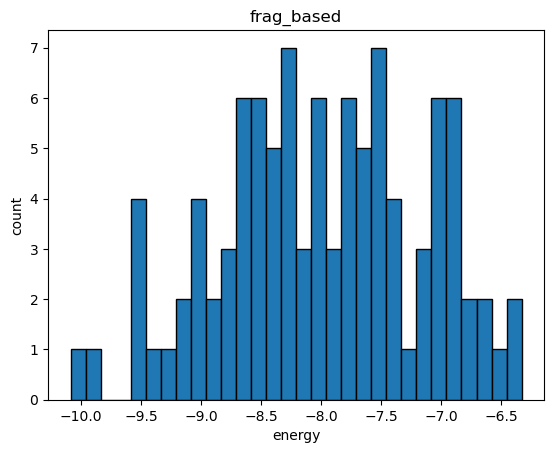

In [23]:
import matplotlib.pyplot as plt
f_data = open(f"results/{name}/scores.txt")
lines = f_data.readlines()
f_data.close()
values = [float(s.split()[1]) for s in lines if len(s.split())>0 and len(s)>0]
# Create histogram
plt.hist(values, bins=30, edgecolor='black')  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel('energy')
plt.ylabel('count')
plt.title('frag_based')

# Show plot
plt.show()

In [293]:
result = s.simulatedAnnealing(ligand='', 
                              start_score=0, 
                              ligand_3d=None, 
                              initial_building_position=[16, -40, 8], 
                              max_mw=500, 
                              temp=300, 
                              coolingSchedule=coolingSchedule,
                              chain_prob=0.5)

[16:40:28] Explicit valence for atom # 16 O, 3, is greater than permitted
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 17 27 28 29 30
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[16:40:28] SMILES Parse Error: ring closure 1 duplicates bond between atom 16 and atom 17 for input: 'c1(sc(nn1)N)c1c(OC(C(C1(C(=C(C(=CC1c1ccc(cc1)F)c1ccccc1)C#N)N)(C#N)C#N))C)cccc1'
[16:40:28] Explicit valence for atom # 4 N, 6, is greater than permitted
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 25 26 27
[16:40:28] Explicit valence for atom # 16 C, 5, is greater than permitted
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 6 7 11 12 13 14 15 21 22 23 25 37 38 39 40
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 17 28 29 33 34 35 36
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 3

In [294]:
result

(<rdkit.Chem.rdchem.Mol at 0x7efc26e4ee40>,
 'c1(c(n(c2c1cccc2)CCOC)C)C(=O)ON1c2c(C3C(C1C(=O)O)CC=C3)cc(cc2Cl)Cl',
 25.164)

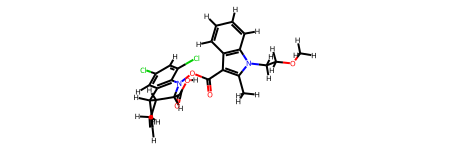

In [295]:
result[0]

In [112]:
Descriptors.HeavyAtomMolWt(result[0])

520.3830000000004

In [ ]:
pdb = s.rdkitToPdbqt(result[0])

f = open('simple.pdbqt', 'w')
f.write(pdb)
f.close()

In [296]:
vina.set_ligand_from_string(s.rdkitToPdbqt(result[0]))
# vina.optimize()

In [138]:
vina.write_pose("ulig11.pdbqt")

In [297]:
vina.score()

array([ 25.164,  36.197,   0.   ,   0.   ,   0.   ,   1.894, -11.033,
         1.894])

In [298]:
vina.dock(n_poses=1)

Performing docking (random seed: -1820654799) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.767          0          0


In [ ]:
vina.write_poses('out.pdbqt', n_poses=1, overwrite=True)

In [299]:
vina.energies()

array([[ -8.767, -12.61 ,  -0.717,   3.844,  -0.717]])

In [141]:
vina.write_pose("lig11.pdbqt")

In [121]:
def read_pdbqt(filename):
    mol = next(pb.readfile("pdbqt", filename))
    return Chem.MolFromMolBlock(mol.write("mol"))

In [122]:
mol = read_pdbqt("lig6.pdbqt")

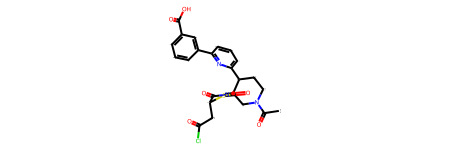

In [123]:
mol

In [142]:
c = mol.GetConformer()

In [144]:
for i in range(c.GetNumAtoms()):
    pos = c.GetAtomPosition(i)
    print(pos.x, pos.y, pos.z)

23.224 -41.728 9.705
24.658 -41.539 9.373
25.559 -42.694 9.631
24.941 -43.966 9.407
25.68 -45.014 8.825
25.16 -46.132 8.622
27.09 -44.8 8.447
23.582 -44.171 9.779
22.635 -43.081 9.433
22.056 -43.206 8.084
22.851 -43.155 6.939
24.084 -43.042 6.758
21.732 -43.291 5.545
20.355 -43.976 6.553
20.681 -43.379 7.853
19.776 -43.057 8.679
20.6 -45.483 6.569
19.344 -46.239 6.462
18.372 -45.807 7.057
19.172 -47.716 5.533
21.262 -40.224 9.494
20.547 -39.207 8.953
21.127 -38.537 7.903
22.394 -38.892 7.421
23.017 -39.933 8.044
22.461 -40.627 9.101
19.233 -38.869 9.476
18.891 -37.631 9.924
17.618 -37.336 10.42
16.666 -38.315 10.463
16.991 -39.579 10.013
18.254 -39.843 9.529
17.334 -35.993 10.882
16.574 -35.85 11.874
17.867 -34.859 10.272


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
f = open("result.txt")

energy = []
for line in f.readlines():
    if line == "": continue
    energy.append(float(line.split(',')[1]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Binding affinity')

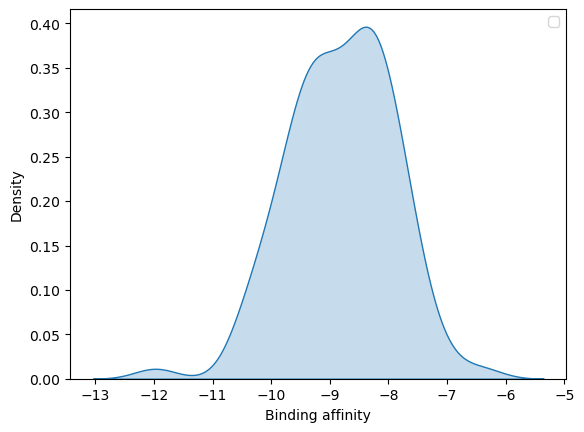

In [19]:
sns.kdeplot(energy, fill=True)
plt.legend()
plt.xlabel('Binding affinity')

<Axes: ylabel='Count'>

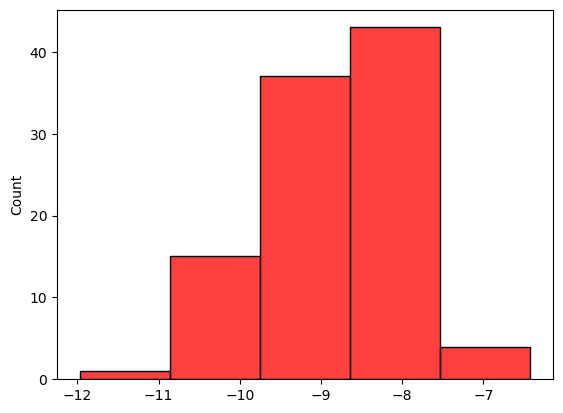

In [17]:
sns.histplot(energy, fill=True, color='red', label='vina', bins=5)

In [14]:
energy

['-9.525',
 '-9.029',
 '-9.486',
 '-9.573',
 '-9.347',
 '-8.671',
 '-9.113',
 '-7.696',
 '-7.958',
 '-8.588',
 '-9.241',
 '-8.564',
 '-8.365',
 '-7.954',
 '-7.735',
 '-8.773',
 '-8.471',
 '-10.268',
 '-6.419',
 '-8.165',
 '-9.353',
 '-9.469',
 '-10.39',
 '-9.806',
 '-9.327',
 '-7.554',
 '-11.973',
 '-7.909',
 '-7.723',
 '-8.154',
 '-9.028',
 '-8.62',
 '-7.634',
 '-9.436',
 '-8.356',
 '-10.504',
 '-7.111',
 '-9.121',
 '-8.314',
 '-9.533',
 '-8.885',
 '-8.973',
 '-9.444',
 '-8.038',
 '-9.947',
 '-7.489',
 '-7.576',
 '-10.443',
 '-8.693',
 '-9.063',
 '-10.157',
 '-8.055',
 '-8.128',
 '-10.125',
 '-9.809',
 '-9.354',
 '-8.981',
 '-8.447',
 '-10.32',
 '-9.81',
 '-9.396',
 '-8.201',
 '-9.551',
 '-9.126',
 '-8.514',
 '-9.035',
 '-7.167',
 '-8.379',
 '-8.361',
 '-8.631',
 '-8.098',
 '-7.96',
 '-9.825',
 '-8.951',
 '-8.237',
 '-9.989',
 '-9.075',
 '-8.578',
 '-8.194',
 '-7.644',
 '-7.814',
 '-9.34',
 '-8.701',
 '-9.831',
 '-8.319',
 '-9.877',
 '-9.208',
 '-8.163',
 '-9.63',
 '-8.362',
 '-8.84',